In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [101]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [102]:
@test 
def bicycle_model(curr_pose, v, delta, dt=1.0):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0) (1.0, 0.0, 1.111111111111111)
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1.11) 
    '''
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    x, y, theta =curr_pose 
    x+= v*np.cos(theta)*dt
    y+= v*np.sin(theta)*dt
    theta+= ((v*np.tan(delta))/0.9)*dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x, y, theta

Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expecting:
    (0.0, 0.0, 0.0) (1.0, 0.0, 1.111111111111111)
**********************************************************************
File "__main__", line 6, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expected:
    (0.0, 0.0, 0.0) (1.0, 0.0, 1.111111111111111)
Got:
    (0.0, 0.0, 0.0)
Trying:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expecting:
    (1.0, 0.0, 1.11) 
**********************************************************************
File "__main__", line 8, in bicycle_model
Failed example:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expected:
    (1.0, 0.0, 1.11) 
Got:
    (1.0, 0.0, 1.111111111111111)


In [103]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
straight_trajectory.append(pose)
steps = 10
#fill in v and delta values
v =1 
delta =0
for _ in range(steps):
   #instruction to take v, delta and compute new pose    
    pose=bicycle_model(pose,v,delta)
   # store new pose
    straight_trajectory.append(pose)
straight_trajectory=np.array(straight_trajectory)
print(straight_trajectory)

[[0.00000000e+00 0.00000000e+00 1.57079633e+00]
 [6.12323400e-17 1.00000000e+00 1.57079633e+00]
 [1.22464680e-16 2.00000000e+00 1.57079633e+00]
 [1.83697020e-16 3.00000000e+00 1.57079633e+00]
 [2.44929360e-16 4.00000000e+00 1.57079633e+00]
 [3.06161700e-16 5.00000000e+00 1.57079633e+00]
 [3.67394040e-16 6.00000000e+00 1.57079633e+00]
 [4.28626380e-16 7.00000000e+00 1.57079633e+00]
 [4.89858720e-16 8.00000000e+00 1.57079633e+00]
 [5.51091060e-16 9.00000000e+00 1.57079633e+00]
 [6.12323400e-16 1.00000000e+01 1.57079633e+00]]


In [104]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
v =0.9
delta =np.pi/4
for _ in range(steps*100):
    #instruction to take v, delta and compute new pose    
    pose=bicycle_model(pose,v,delta,0.01)
   # store new pose
    circle_trajectory.append(pose)
circle_trajectory=np.array(circle_trajectory)
print(circle_trajectory)


[[ 5.51091060e-19  9.00000000e-03  1.58079633e+00]
 [-8.99985000e-05  1.79995500e-02  1.59079633e+00]
 [-2.69986500e-04  2.69977501e-02  1.60079633e+00]
 ...
 [-1.66716330e+00 -4.66090820e-01 -1.01557429e+00]
 [-1.66241911e+00 -4.73738870e-01 -1.00557429e+00]
 [-1.65759868e+00 -4.81339098e-01 -9.95574288e-01]]


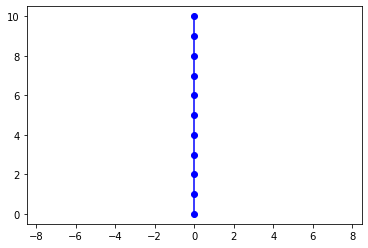

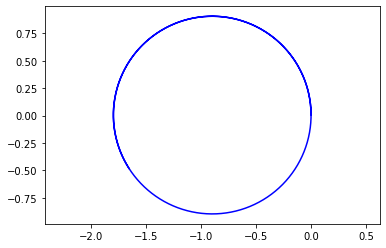

In [105]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0],straight_trajectory[:,1],'-ob')

plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circle_trajectory[:,0],circle_trajectory[:,1],'-b')


### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [106]:
#assuming 
l=0.9
vc = 1                       # m/s
deltac=np.pi/12                     #rad/s (So that t_turn is an integer)
wc=(vc/l)*np.tan(deltac)    #rad

#calculate time taken to finish a quarter turn (pi/4)
#unlike you would need to take into account v_c and L of the vehicle as well
t_turn = int(np.round_((np.pi/4)/wc))

#calculate the time taken to finish straight segments
#delta array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 =int(10/vc),int(5/vc),int(8/vc)

all_delta = [0]*t_straight1 + [-deltac]*t_turn + \
        [0]*t_straight2 + [deltac]*t_turn + \
        [0]*t_straight3 + [-deltac]*t_turn
all_v = vc*np.ones_like(all_delta)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [107]:
#introducing vc_turn won't have much effect on turning because as vc_turn changes so does wc and the effect almost cancels out
def get_open_loop_commands(route,vc_straight=1, deltac=np.pi/12, dt=1,):
  wc=(vc_straight/0.9)*np.tan(deltac)
  all_delta = []
  all_v= []
  deltas = {'straight': 0, 'left': deltac, 'right': -deltac}
  #trans = {'straight': vc_straight, 'left': vc_turn, 'right': vc_turn}
  for manoeuvre, command in route:
    if manoeuvre=='straight':
      t_cmd= np.round_(command/vc_straight).astype('int')
    else:
      t_cmd = np.round_(np.deg2rad(command)/wc).astype('int')
    all_delta += [deltas[manoeuvre]]*t_cmd*int(1/dt)
    #all_v+=[trans[manoeuvre]]*t_cmd*int(1/dt)
  all_v=vc_straight*np.ones_like(all_delta)
  return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [108]:
all_v, all_delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])

In [109]:
robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
robot_trajectory.append(pose)
dt=0.01
all_v, all_delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)],dt=dt)
for v, delta in zip(all_v, all_delta):
    #instruction to take v, delta and compute new pose
    pose=bicycle_model(pose,v,delta,dt)    
    # store new pose
    robot_trajectory.append(pose)
robot_trajectory=np.array(robot_trajectory)

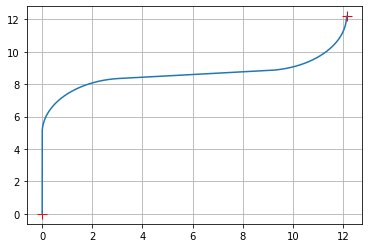

In [110]:
# plot robot trajectory
plt.figure()
plt.grid()
#plt.plot( )

#show first and last robot positions with + markers
xi,yi,_=robot_trajectory[0]
xf,yf,_=robot_trajectory[-1]
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'r+', ms=10)
plt.plot(robot_trajectory[:,0],robot_trajectory[0:,1])


### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2\theta^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [111]:
#assume x is linear function of time t
#time_i is the starting time and time_f is the destination time,time_step is difference between two times or in other words dt
def poly_turn(theta_i, theta_f,time_i,time_f,n=30):
    x = np.linspace(0, 1, num=n)
    t=(time_f-time_i)*x+ time_i
    time_step=t[2]-t[1]
    theta=(theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f
    theta_dot=(theta_i-theta_f) * (- 6 * x+ 6 * (x**2))*(1/(time_f-time_i))
    return t,theta,theta_dot,time_step

How does a right turn look? 

In [114]:
#right turn from North to East.Assumed, angles are measured from positive x-axis and north is along positive y-axis and east along positive x axis
v=1   #m/sec
l=0.9  #m
trajectory=[]
pose=(0,0,np.pi/2)
trajectory.append(pose)
theta_i=np.pi/2
theta_f=0
time_i=0
time_f=3   ## we can change the inial and final time according to our requirements
_,_,theta_dot,time_step=poly_turn(theta_i,theta_f,time_i,time_f)  
all_delta=np.arctan((l*theta_dot)/v)
all_v=v*np.ones_like(all_delta)
for v,delta in zip(all_v,all_delta):
  pose=bicycle_model(pose,v,delta,time_step)
  trajectory.append(pose)
trajectory=np.array(trajectory)
print(trajectory)





[[0.00000000e+00 0.00000000e+00 1.57079633e+00]
 [6.33438000e-18 1.03448276e-01 1.57079633e+00]
 [1.26687600e-17 2.06896552e-01 1.55997613e+00]
 [1.11930888e-03 3.10338772e-01 1.53910861e+00]
 [4.39680027e-03 4.13735115e-01 1.50896663e+00]
 [1.07889012e-02 5.16985717e-01 1.47032307e+00]
 [2.11652080e-02 6.19912284e-01 1.42395080e+00]
 [3.63015885e-02 7.22247203e-01 1.37062268e+00]
 [5.68711930e-02 8.23629831e-01 1.31111160e+00]
 [8.34342131e-02 9.23609587e-01 1.24619042e+00]
 [1.16427520e-01 1.02165543e+00 1.17663201e+00]
 [1.56155457e-01 1.11717107e+00 1.10320925e+00]
 [2.02783080e-01 1.20951505e+00 1.02669500e+00]
 [2.56333018e-01 1.29802465e+00 9.47862132e-01]
 [3.16686887e-01 1.38204225e+00 8.67483526e-01]
 [3.83591844e-01 1.46094264e+00 7.86332049e-01]
 [4.56672477e-01 1.53415990e+00 7.05180572e-01]
 [5.35447772e-01 1.60121211e+00 6.24801967e-01]
 [6.19352493e-01 1.66172280e+00 5.45969103e-01]
 [7.07761923e-01 1.71543796e+00 4.69454854e-01]
 [8.00018652e-01 1.76223798e+00 3.960320

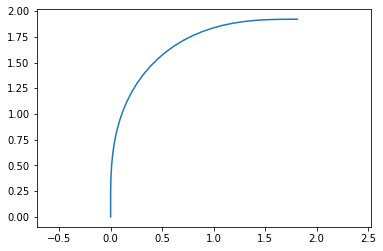

In [115]:
plt.figure()
plt.axes().set_aspect('equal','datalim')
plt.plot(trajectory[:,0],trajectory[:,1],'-')



Now plot a left turn (North to East)

[[ 0.00000000e+00  0.00000000e+00  1.57079633e+00]
 [ 4.22292000e-18  6.89655172e-02  1.57079633e+00]
 [ 8.44583999e-18  1.37931034e-01  1.58161652e+00]
 [-7.46205917e-04  2.06892515e-01  1.60248405e+00]
 [-2.93120018e-03  2.75823410e-01  1.63262602e+00]
 [-7.19260083e-03  3.44657145e-01  1.67126958e+00]
 [-1.41101386e-02  4.13274856e-01  1.71764186e+00]
 [-2.42010590e-02  4.81498135e-01  1.77096997e+00]
 [-3.79141286e-02  5.49086554e-01  1.83048105e+00]
 [-5.56228088e-02  6.15739725e-01  1.89540223e+00]
 [-7.76183466e-02  6.81103621e-01  1.96496064e+00]
 [-1.04103638e-01  7.44780712e-01  2.03838341e+00]
 [-1.35188720e-01  8.06343365e-01  2.11489766e+00]
 [-1.70888679e-01  8.65349767e-01  2.19373052e+00]
 [-2.11124591e-01  9.21361497e-01  2.27410913e+00]
 [-2.55727896e-01  9.73961761e-01  2.35526060e+00]
 [-3.04448318e-01  1.02277327e+00  2.43641208e+00]
 [-3.56965181e-01  1.06747474e+00  2.51679069e+00]
 [-4.12901662e-01  1.10781520e+00  2.59562355e+00]
 [-4.71841282e-01  1.14362531e+

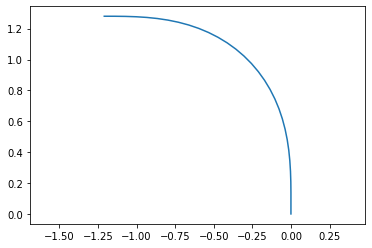

In [118]:
#left turn from North to West.Assumed, angles are measured from positive x-axis and north is along positive y-axis and west along negative x axis
v=1   #m/sec
l=0.9  #m
trajectory=[]
pose=(0,0,np.pi/2)
trajectory.append(pose)
theta_i=np.pi/2
theta_f=np.pi
time_i=0
time_f=2
_,_,theta_dot,time_step=poly_turn(theta_i,theta_f,time_i,time_f)  
all_delta=np.arctan((l*theta_dot)/v)
all_v=v*np.ones_like(all_delta)
for v,delta in zip(all_v,all_delta):
  pose=bicycle_model(pose,v,delta,time_step)
  trajectory.append(pose)
trajectory=np.array(trajectory)
print(trajectory)

plt.figure()
plt.axes().set_aspect('equal','datalim')
plt.plot(trajectory[:,0],trajectory[:,1],'-')



How does $\theta$ change when we had constant $\delta$? Plot it

[0.         0.16540074 0.33080147 0.49620221 0.66160294 0.82700368
 0.99240442 1.15780515 1.32320589 1.48860662]


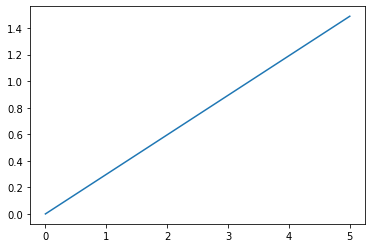

In [119]:
l=0.9
v=1
delta=np.pi/12
omega=(v/l)*np.tan(delta)
distance=np.pi/2
time=int(np.round_(distance/omega))
time_div=np.linspace(0,time,10)
theta=omega*time_div
print(theta)
plt.figure()
plt.plot(time_div,theta,'-')

We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?

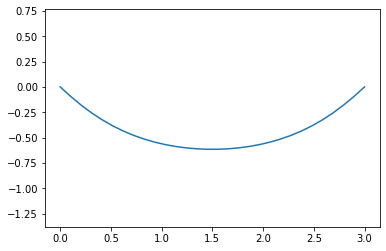

In [125]:
l=0.9   #m
v=1     #m/sec
theta_i=np.pi/2
theta_f=0  
time_i=0
time_f=3
time,_,theta_dot,_=poly_turn(theta_i,theta_f,time_i,time_f)
delta=np.arctan((l*theta_dot)/v)

plt.figure()
plt.axes().set_aspect('equal','datalim')
plt.plot(time,delta,'-')